### UK/NI masking ###

Minor correction to blank NI and Shetland out of UK mask for temperature.

In [1]:
# Local imports
import os
import sys
import time
import argparse

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.io.shapereader as shpreader
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

# load the dictionaries
import dictionaries as dic

# Load my specific functions
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import create_masked_matrix
from unseen_analogs_functions import regrid_obs_to_model

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
test_file_path = "/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1961-r9i1p1f2/day/tas/gn/files/d20200417/tas_day_HadGEM3-GC31-MM_dcppA-hindcast_s1961-r9i1p1f2_gn_19720101-19720330.nc"

# load this in with iris
cube = iris.load_cube(test_file_path, "tas")

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/fileformats/cf.py:880: IrisCfMissingVarWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tas'
  warnings.warn(


In [3]:
# Ensure is on the correct grid
# ensure that hadgem is in -180 to 180
cube = cube.intersection(longitude=(-180, 180))

In [4]:
# Create the masked matrix
MASK_MATRIX = create_masked_matrix(
    country="United Kingdom",
    cube=cube,
)

Found Country United Kingdom


In [5]:
# Extract the lats and lons
lats = cube.coord("latitude").points
lons = cube.coord("longitude").points

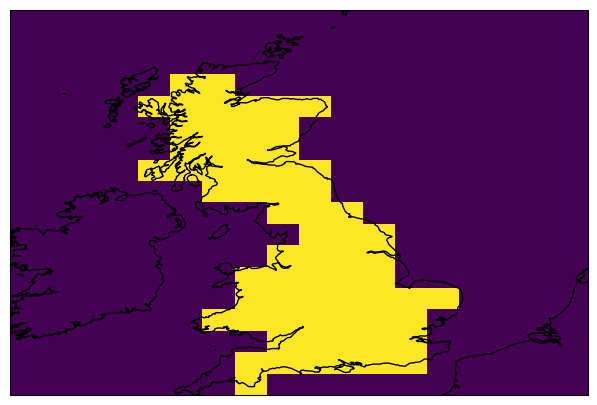

In [7]:
import cartopy.crs as ccrs

# Set up a figure
fig = plt.figure(figsize=(10, 5))

# Set up a projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Add the coastlines
ax.coastlines()

# Plot the mask
plt.pcolormesh(lons, lats, MASK_MATRIX, transform=ccrs.PlateCarree(), cmap="viridis")

# set the extent
ax.set_extent([-10, 5, 50, 60])

Seems to be applying this correctly, to the model at least. Do the same for the obs?

In [8]:
test_obs_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_wind_daily_1960_1965.nc"

# load this in with iris
obs_cube = iris.load_cube(test_obs_path, "si10")

In [9]:
# Make sure the obs is on the same grid
obs_cube  = obs_cube.regrid(cube, iris.analysis.Linear())

In [10]:
# apply the mask
MASK_MATRIX_OBS = create_masked_matrix(
    country="United Kingdom",
    cube=obs_cube,
)

Found Country United Kingdom


In [11]:
# Extract the obs lats and lons
lats_obs = obs_cube.coord("latitude").points
lons_obs = obs_cube.coord("longitude").points

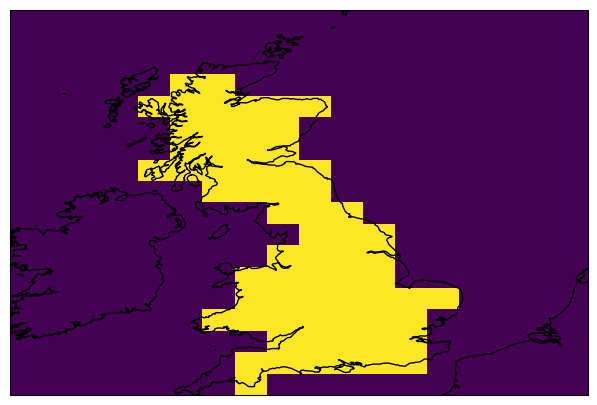

In [12]:
import cartopy.crs as ccrs

# Set up a figure
fig = plt.figure(figsize=(10, 5))

# Set up a projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Add the coastlines
ax.coastlines()

# Plot the mask
plt.pcolormesh(lons_obs, lats_obs, MASK_MATRIX_OBS, transform=ccrs.PlateCarree(), cmap="viridis")

# set the extent
ax.set_extent([-10, 5, 50, 60])

In [13]:
# apply the mask
obs_data = obs_cube.data

# apply the mask
obs_values = obs_data * MASK_MATRIX_OBS

# Where there are zeros we want to set these to NaNs
obs_values = np.where(obs_values == 0, np.nan, obs_values)

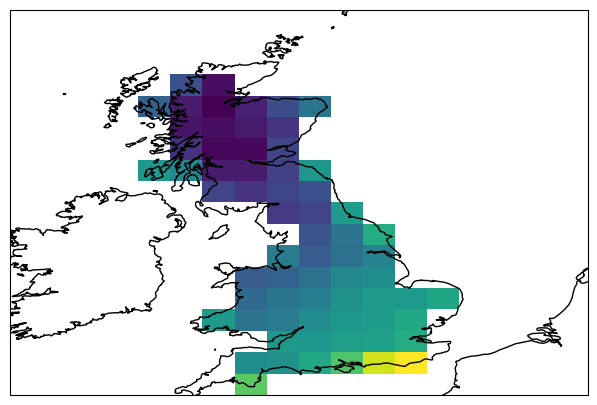

In [14]:
# Set up a figure
fig = plt.figure(figsize=(10, 5))

# Set up a projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Add the coastlines
ax.coastlines()

# Plot the mask
plt.pcolormesh(lons_obs, lats_obs, obs_values[0, :, :], transform=ccrs.PlateCarree(), cmap="viridis")

# set the extent
ax.set_extent([-10, 5, 50, 60])

# show the plot
plt.show()